# 설치 목록


In [ ]:
# ! pip install albumentations==0.4.6
# ! pip install wandb
# ! pip install timm
# !pip install MADGRAD

# EDA

In [ ]:
import torch
import numpy as np
import pandas as pd
# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import glob
import os
plt.rcParams['axes.grid'] = False

import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Le's Go~!

[329, 205, 235, 134, 151, 245, 399]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


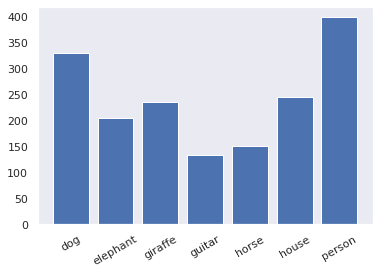

In [ ]:
classes = ['dog', 'elephant', 'giraffe','guitar','horse','house','person']
num_classes = []
for name in classes :
  path = '/content/input/train/' + name
  num_classes.append(len(glob.glob(os.path.join(path, '*.jpg'))))
print(num_classes)
plt.bar(range(len(num_classes)), num_classes)
ax = plt.subplot()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6,])
ax.set_xticklabels(classes, rotation=30)
plt.show()

In [ ]:
plt.figure(figsize = (20,15))
for i , label in enumerate(classes):
    for j in range(4) :
      plot= plt.subplot(7, 4, 4*i + j+1 )
      plt.axis('off')

      img_path = os.path.join('/content/input/test/0' , '00' + str(4*i + j+41)+ '.jpg')
      img = plt.imread(img_path)
      plt.imshow(img)

In [ ]:
plt.figure(figsize = (20,15))
for i , label in enumerate(classes):
    for j in range(4) :
      plot= plt.subplot(7, 4, 4*i + j+1 )
      plt.axis('off')

      img_path = os.path.join(os.path.join('/content/input/train' , label) , 'pic_00' + str(j+1)+ '.jpg')
      img = plt.imread(img_path)
      plt.imshow(img)

In [ ]:
import os
import numpy as np 
import pandas as pd
import random
import wandb 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

from importlib import import_module
from tqdm import tqdm
import timm
from PIL import Image
import cv2

# utils


In [ ]:
# seed 고정 
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

# lr for wandb
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# save model
def save_model(model, version, save_type='acc'):
    save_path = os.path.join(f'./ckpts/{version}')
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    save_dir = os.path.join(save_path, f'best_{save_type}.pth')
    torch.save(model.state_dict(), save_dir)

################## CUTMIX #################################
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)
    image_batch[:, :, bbx1:bbx2, bby1:bby2] = image_batch[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    
    return target_a , target_b , lam

In [ ]:
def make_df():
  all_img_files = []
  all_labels = []
  class_names = {'dog':0 ,'elephant':1 , 'giraffe':2 , 'guitar':3 , 'horse':4 , 'house' : 5 , 'person' : 6}
  for name , label in class_names.items():
      img_folder = os.path.join('/content/input/train' , name)
      for file_name in os.listdir(img_folder):
          file_name = os.path.join(img_folder, file_name)
          all_img_files.append(file_name)
          all_labels.append(label)
  
  df = pd.DataFrame({'img_path' : all_img_files, 'label' : all_labels})
  return df

# Dataset

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data , transform = None ):
      self.data = data  
      self.transform = transform

    def __getitem__(self, idx):
        image_path , label = self.data['img_path'].iloc[idx] , self.data['label'].iloc[idx]
        images = cv2.imread(image_path)
        image = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.uint8)

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]     
            return {'image' : image, 'label' : label}

    def __len__(self):
      return len(self.data)

# Model

In [ ]:
# Model 
class EfficientNet(nn.Module):
    def __init__(self , num_classes = 7):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b4' , pretrained = True)
        self.backbone.classifier = nn.Linear(1792,num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x

class Swin(nn.Module):
    def __init__(self , num_classes = 7):
        super().__init__()
        self.backbone = timm.create_model('swin_base_patch4_window7_224_in22k' , pretrained = True)
        self.backbone.head = nn.Linear(1024,num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x

class NFNet(nn.Module):
    def __init__(self , num_classes = 7):
        super().__init__()
        self.backbone = timm.create_model('dm_nfnet_f3' , pretrained = True)
        self.backbone.head.fc = nn.Linear(3072,num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x  

# Loss


In [ ]:
## LOSS Function
# for weighted CE 
weights = [sum(num_classes)/w for w in num_classes]

# LabelSmoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=7, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

# Focal
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=.25, weights=None):   
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.weight = weights

    def forward(self, inputs, targets):
        """Computes the FocalLoss
        Notes: [Batch size,Num classes,Height,Width]
        Args:
            targets: a tensor of shape [B, H, W] or [B, 1, H, W].
            inputs: a tensor of shape [B, C, H, W]. Corresponds to
                the raw output or logits of the model. (prediction)
        Returns:
            focal loss : -alpha *(1-p)*gamma * log(p)
        """
        logp = F.log_softmax(inputs, dim=1)
        ce_loss = F.nll_loss(logp, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)

        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()

# train

In [ ]:
def train( train_loader, val_loader,  model,  optimizer ,criterion , scheduler):
    
    early_stop = EARLY_STOP
    cnt = 0
    
    best_val_acc = 0
    best_val_loss = np.inf
    
    for epoch in range(NUM_EPOCHS):
        if early_stop < cnt : break

        # train loop
        model.train()
        
        train_loss_value = 0
        train_acc_value = 0
        
        with tqdm(train_loader, total = len(train_loader) , unit = 'batch') as train_bar :
            for batch, sample in enumerate(train_bar):
                images = sample['image'].to(device)
                labels = sample['label'].to(device)

                r = np.random.rand(1)
                if r > CUTMIX and CUTMIX > 0 :
                    target_a , target_b , lam = generate_cutmix_image(images , labels , CutMix)
                    outputs = model(images)
                    preds = outputs.argmax(1)   
                    loss = criterion(outs, target_a) * lam + criterion(outs, target_b) * (1. - lam)

                else :
                    outputs = model(images)
                    preds = outputs.argmax(1)            
                    loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                train_loss_value += loss.item()
                train_acc_value += (preds == labels).sum().item()

                train_mean_loss = train_loss_value / TRAIN_BATCHSIZE
                train_mean_value = ( train_acc_value / (batch + 1) / TRAIN_BATCHSIZE ) * 100.0

                wandb.log({
                    'Learning rate': get_lr(optimizer),
                    'Train Loss value': train_mean_loss, 
                    'Train mean acc value': train_mean_value
                })

                train_bar.set_postfix(trn_loss=train_mean_loss, trn_acc=train_mean_value)

        # train loop
        model.eval()
        
        val_loss_value = 0
        val_acc_value = 0
        with torch.no_grad():
            with tqdm(val_loader, total = len(val_loader) , unit = 'batch') as val_bar :
                for batch, sample in enumerate(val_bar):
                    images = sample['image'].to(device)
                    labels = sample['label'].to(device)

                    outputs = model(images)
                    preds = outputs.argmax(1)            
                    loss = criterion(outputs, labels)

                    val_loss_value += loss.item()
                    val_acc_value += (preds == labels).sum().item()


        val_mean_loss = val_loss_value / VAL_BATCHSIZE
        val_mean_acc = (val_acc_value / (batch + 1) / VAL_BATCHSIZE ) * 100.0

        val_bar.set_postfix(val_loss=val_mean_loss, val_acc=val_mean_acc)   

        wandb.log({
            'Val Loss value': val_mean_loss,
            'Val mean acc value': val_mean_acc
        })

        ## save model 
        if best_val_acc < val_mean_acc:
            best_val_acc = val_mean_acc
            save_model(model, version = RUN_NAME)
        
    wandb.finish()

# Main

In [ ]:
# Hyperparamter 
TRAIN_BATCHSIZE = 16
VAL_BATCHSIZE =  16
NUM_WORKERS = 3
SEED = 42
IMG_SIZE =320
EARLY_STOP = 5
LR = 1e-4
NUM_EPOCHS = 20
CUTMIX = 0
#
OPTIMIZER = 'AdamW'
SAVE_PATH = '/content/drive/MyDrive/saved'
RUN_NAME = "E4_swin"
# device 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
wandb_config={"lr" : LR , "epochs": NUM_EPOCHS, "train_batch_size": TRAIN_BATCHSIZE , "val_batch_size" : VAL_BATCHSIZE , "num_workers" : NUM_WORKERS , "seed" : SEED , "img_size" : IMG_SIZE }

In [ ]:
# define augmentation
train_transform = A.Compose([
      A.Resize (IMG_SIZE, IMG_SIZE , p=1),
      A.OneOf([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit = 30)
        ]),
      A.RandomResizedCrop (p=1 , height= 224 , width = 224, ratio = (0.75 , 1.25) , scale = (0.7,1.0) ),
      A.Cutout(num_holes = 6 , max_h_size = 20 , max_w_size = 20 , p=1),
      A.HueSaturationValue (p=0.5),
      A.Normalize(),
      ToTensorV2()
    ])

val_transform = A.Compose([
        A.Normalize(),
        A.Resize (224 , 224 , p=1),
        ToTensorV2()
    ])


# dataset 구성
dataset = make_df()
label = dataset['label']
train_x, val_x , train_y , val_y = train_test_split(dataset, label , test_size = 0.2 , random_state = SEED ,shuffle = True, stratify = label)


train_dataset = CustomDataset( train_x  , train_transform)
val_dataset = CustomDataset( val_x  , val_transform)

  
# dataloader 구성 
train_loader = DataLoader(train_dataset, batch_size = TRAIN_BATCHSIZE, shuffle = True, num_workers = NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size = VAL_BATCHSIZE, shuffle = True, num_workers = NUM_WORKERS)

# model 
model =  Swin(num_classes=7)
model.to(device)

# loss
criterion = nn.CrossEntropyLoss()  # default: cross_entropy

# optimizer 
if OPTIMIZER == 'MADGRAD' :
    optimizer = MADGRAD(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=LR,
                        weight_decay=5e-4)
else :
    opt_module = getattr(import_module("torch.optim"), OPTIMIZER)  # default: SGD
    optimizer = opt_module(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR,
        weight_decay=5e-4
    )

# scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 1000 , T_mult = 2 , eta_min = 5e-5 )

# TRAIN
wandb.login()
wandb.init(project='Image classficiation', name=RUN_NAME, config = wandb_config)
train(train_loader, val_loader , model , optimizer ,criterion , scheduler )

# Inference

In [ ]:
# INFERENCE DATASETCODE
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data_path , transform = None ):
      self.data_path = data_path
      self.data = sorted(os.listdir('/content/input/test/0'))
      self.transform = transform

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_path , self.data[idx])
        images = cv2.imread(image_path)
        image = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.uint8)

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]     
            return {'image' : image , 'image_path' : image_path}

    def __len__(self):
      return len(self.data)

In [ ]:
# INFERENCE
test_transform = A.Compose([
        A.Normalize(),
        A.Resize (224 , 224 , p=1),
        ToTensorV2()
    ])

test_dataset = TestDataset('/content/input/test/0' , test_transform)

# dataloader 구성 
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = NUM_WORKERS)

model1 = Swin(num_classes=  7)
model1.load_state_dict(torch.load('/content/ckpts/E4_swin/best_acc.pth'))
model1.to(device)

model2 = NFNet(num_classes = 7)
model2.load_state_dict(torch.load('/content/ckpts/E4_NFNet3/best_acc.pth'))
model2.to(device)
submission = []
model1.eval()
model2.eval()
with torch.no_grad():
    with tqdm(test_loader, total = len(test_loader) , unit = 'batch') as test_bar :
        for batch, sample in enumerate(test_bar):
            images = sample['image'].to(device)
            image_path = sample['image_path']

            # outputs1= model1(images)
            # outputs2 =model2(images)
            # outputs = (outputs1 + outputs2) / 2
            outputs = model(images)
            preds = outputs.argmax(1)
            submission.extend(preds.cpu().numpy())

submission.head()

100%|██████████| 350/350 [00:27<00:00, 12.52batch/s]


In [ ]:
submission_csv = pd.read_csv('/content/input/test_answer_sample_.csv',index_col = 0)
submission_csv['answer value'] = submission
submission_csv.head()
submission_csv.to_csv('/content/input/swin.csv')

# visualization for augmentation


In [ ]:
image = cv2.imread('/content/input/test/0/0001.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def visualize(image):
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image)

visualize(image)

transform = A.Compose([
                      A.HueSaturationValue (p=1)
                       ])
augmented_image = transform(image=image)['image']
visualize(augmented_image)